# MAG7 Stock Analysis: Quantitative Finance Volatility Modeling

This notebook implements specialized financial volatility models (EWMA and GARCH) and compares them against generic time series approaches. We analyze AAPL, NVDA, and the equal weighted MAG7 portfolio to demonstrate that financial volatility requires domain-specific modeling techniques that capture volatility clustering, persistence, and conditional heteroskedasticity.

## 1. Setup & Data Load

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [20]:
# Load returns and realized volatility data
returns_df = pd.read_csv('./data/processed/returns_log.csv', parse_dates=['Date'], index_col='Date')
rv_df = pd.read_csv('./data/processed/volatility_21d_annualized.csv', parse_dates=['Date'], index_col='Date')
portfolio_df = pd.read_csv('./data/processed/portfolio_equal_weight.csv', parse_dates=['Date'], index_col='Date')

# Focus on AAPL, NVDA, and the equal weighted portfolio
focus_assets = ['AAPL', 'NVDA', 'Portfolio']

print(f"Returns shape: {returns_df.shape}")
print(f"RV shape: {rv_df.shape}")
print(f"Portfolio shape: {portfolio_df.shape}")
print(f"\nDate range: {returns_df.index.min()} to {returns_df.index.max()}")

Returns shape: (2745, 7)
RV shape: (2745, 7)
Portfolio shape: (2745, 2)

Date range: 2015-01-05 00:00:00 to 2025-12-02 00:00:00


In [21]:
# Align data: drop NaN values from RV (first 21 days will be NaN)
valid_idx = rv_df.dropna().index

returns_aligned = returns_df.loc[valid_idx]
rv_aligned = rv_df.loc[valid_idx]
portfolio_aligned = portfolio_df.loc[valid_idx]

print(f"Aligned data shape: {returns_aligned.shape}")
print(f"Date range: {returns_aligned.index.min()} to {returns_aligned.index.max()}")

Aligned data shape: (2725, 7)
Date range: 2015-02-03 00:00:00 to 2025-12-02 00:00:00


In [22]:
# Train-test split: 80% train, 20% test
train_size = int(len(returns_aligned) * 0.8)

train_returns = returns_aligned.iloc[:train_size]
test_returns = returns_aligned.iloc[train_size:]

train_rv = rv_aligned.iloc[:train_size]
test_rv = rv_aligned.iloc[train_size:]

train_portfolio = portfolio_aligned.iloc[:train_size]
test_portfolio = portfolio_aligned.iloc[train_size:]

print(f"Training: {train_returns.index[0]} to {train_returns.index[-1]} ({len(train_returns)} days)")
print(f"Test: {test_returns.index[0]} to {test_returns.index[-1]} ({len(test_returns)} days)")
print(f"\nTrain RV stats (AAPL): mean={train_rv['AAPL'].mean():.4f}, std={train_rv['AAPL'].std():.4f}")
print(f"Test RV stats (AAPL): mean={test_rv['AAPL'].mean():.4f}, std={test_rv['AAPL'].std():.4f}")

Training: 2015-02-03 00:00:00 to 2023-09-29 00:00:00 (2180 days)
Test: 2023-10-02 00:00:00 to 2025-12-02 00:00:00 (545 days)

Train RV stats (AAPL): mean=0.2657, std=0.1257
Test RV stats (AAPL): mean=0.2458, std=0.1187


## 2. EWMA Volatility Model

EWMA estimates volatility using recursive update: $\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2$

Where $\lambda$ is the decay factor (0.94 for daily data per RiskMetrics). This captures volatility clustering by giving more weight to recent observations.

In [23]:
def ewma_volatility(returns, lam=0.94, annualize=True):
    """Compute EWMA volatility estimate."""
    var = np.zeros(len(returns))
    var[0] = returns.iloc[0] ** 2
    
    for t in range(1, len(returns)):
        var[t] = lam * var[t-1] + (1 - lam) * returns.iloc[t-1] ** 2
    
    vol = np.sqrt(var)
    if annualize:
        vol = vol * np.sqrt(252)
    
    return pd.Series(vol, index=returns.index, name=f'EWMA_{returns.name}')

print("✓ EWMA function defined")

✓ EWMA function defined


### 2.1 EWMA for AAPL, NVDA, and Portfolio

In [24]:
# Fit EWMA on all assets
ewma_results = {}

# AAPL and NVDA
for stock in ['AAPL', 'NVDA']:
    full_returns = returns_aligned[stock]
    ewma_vol = ewma_volatility(full_returns, lam=0.94, annualize=True)
    ewma_test = ewma_vol.loc[test_returns.index]
    actual_test_rv = test_rv[stock]
    
    rmse = np.sqrt(mean_squared_error(actual_test_rv, ewma_test))
    mae = mean_absolute_error(actual_test_rv, ewma_test)
    r2 = r2_score(actual_test_rv, ewma_test)
    
    ewma_results[stock] = {
        'ewma_vol_full': ewma_vol,
        'ewma_test': ewma_test,
        'actual_test': actual_test_rv,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"\n{stock} - EWMA: RMSE={rmse:.6f}, MAE={mae:.6f}, R²={r2:.6f}")

# Portfolio
portfolio_returns = portfolio_aligned['Portfolio_Return']
portfolio_rv = portfolio_aligned['Portfolio_RV_21d']

ewma_vol_portfolio = ewma_volatility(portfolio_returns, lam=0.94, annualize=True)
ewma_test_portfolio = ewma_vol_portfolio.loc[test_portfolio.index]
actual_test_portfolio = test_portfolio['Portfolio_RV_21d']

rmse_p = np.sqrt(mean_squared_error(actual_test_portfolio, ewma_test_portfolio))
mae_p = mean_absolute_error(actual_test_portfolio, ewma_test_portfolio)
r2_p = r2_score(actual_test_portfolio, ewma_test_portfolio)

ewma_results['Portfolio'] = {
    'ewma_vol_full': ewma_vol_portfolio,
    'ewma_test': ewma_test_portfolio,
    'actual_test': actual_test_portfolio,
    'rmse': rmse_p,
    'mae': mae_p,
    'r2': r2_p
}

print(f"\nPortfolio - EWMA: RMSE={rmse_p:.6f}, MAE={mae_p:.6f}, R²={r2_p:.6f}")


AAPL - EWMA: RMSE=0.045232, MAE=0.030079, R²=0.854431

NVDA - EWMA: RMSE=0.069418, MAE=0.051132, R²=0.851239

Portfolio - EWMA: RMSE=0.041206, MAE=0.028716, R²=0.854006


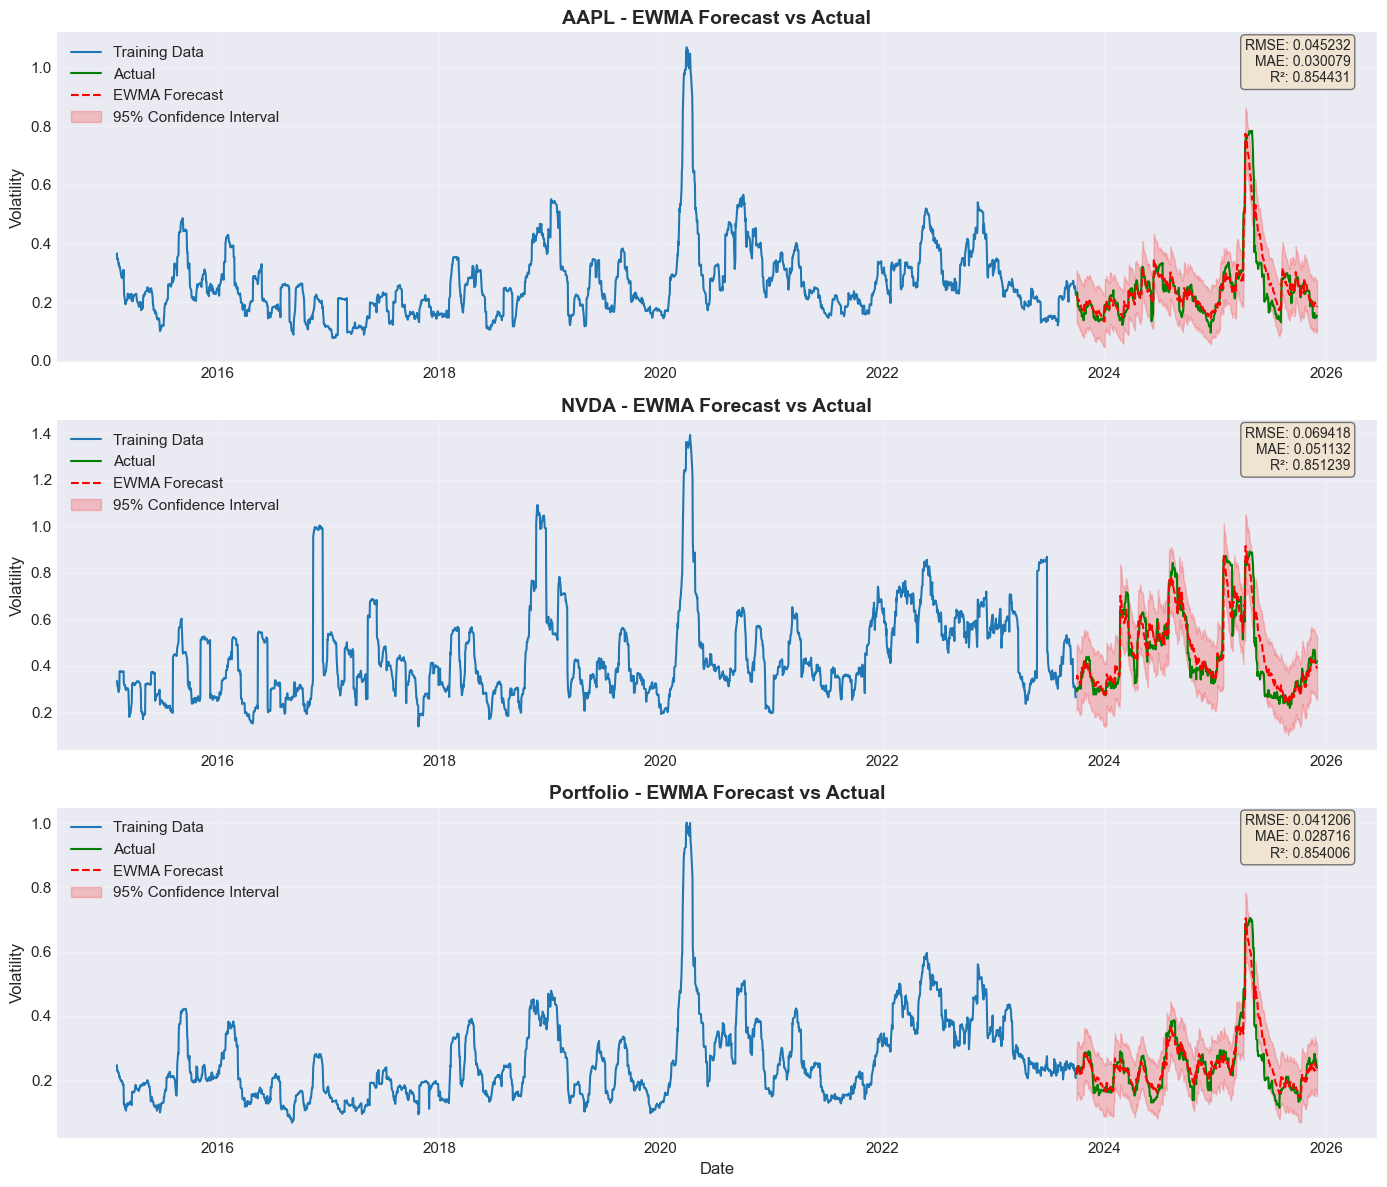

In [25]:
# Plot EWMA results with training and test data
fig, axes = plt.subplots(len(focus_assets), 1, figsize=(14, 12))

for idx, asset in enumerate(focus_assets):
    ax = axes[idx]
    
    # Get data based on asset type
    if asset == 'Portfolio':
        train_actual = train_portfolio['Portfolio_RV_21d']
        test_actual = test_portfolio['Portfolio_RV_21d']
    else:
        train_actual = train_rv[asset]
        test_actual = test_rv[asset]
    
    forecast = ewma_results[asset]['ewma_test']
    
    # Plot training data
    ax.plot(train_actual.index, train_actual, label='Training Data', linewidth=1.5)
    
    # Plot test data
    ax.plot(test_actual.index, test_actual, label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    ax.plot(forecast.index, forecast, label='EWMA Forecast', 
            linewidth=1.5, color='red', linestyle='--')
    
    # Plot confidence interval
    forecast_std = (forecast - test_actual).std()
    ax.fill_between(forecast.index, 
                     forecast - 1.96 * forecast_std, 
                     forecast + 1.96 * forecast_std,
                     alpha=0.2, color='red', label='95% Confidence Interval')
    
    ax.set_title(f'{asset} - EWMA Forecast vs Actual', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatility', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f"RMSE: {ewma_results[asset]['rmse']:.6f}\nMAE: {ewma_results[asset]['mae']:.6f}\nR²: {ewma_results[asset]['r2']:.6f}"
    ax.text(0.98, 0.98, metrics_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 3. GARCH(1,1) Volatility Model

GARCH(1,1) models conditional variance: $\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$

Where $\alpha$ captures impact of recent shocks and $\beta$ captures volatility persistence. Constraint: $\alpha + \beta < 1$ ensures stationarity.

### 3.1 GARCH(1,1) for AAPL, NVDA, and Portfolio

In [26]:
# Fit GARCH(1,1) models
garch_results = {}

# AAPL and NVDA
for stock in ['AAPL', 'NVDA']:
    print(f"Fitting GARCH(1,1) for {stock}...")
    
    train_ret = train_returns[stock] * 100
    test_ret = test_returns[stock] * 100
    
    model = arch_model(train_ret, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
    fitted = model.fit(disp='off', show_warning=False)
    print(fitted.summary())
    
    # Rolling one-step-ahead forecasts
    forecast_horizon = len(test_ret)
    forecasts_list = []
    
    for i in range(forecast_horizon):
        current_data = pd.concat([train_ret, test_ret.iloc[:i]]) if i > 0 else train_ret
        temp_model = arch_model(current_data, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
        temp_fit = temp_model.fit(disp='off', show_warning=False)
        forecast = temp_fit.forecast(horizon=1)
        var_forecast = forecast.variance.values[-1, 0]
        forecasts_list.append(var_forecast)
    
    garch_vol = np.sqrt(np.array(forecasts_list)) / 100 * np.sqrt(252)
    garch_vol_series = pd.Series(garch_vol, index=test_returns.index, name=f'GARCH_{stock}')
    actual_test_rv = test_rv[stock]
    
    rmse = np.sqrt(mean_squared_error(actual_test_rv, garch_vol_series))
    mae = mean_absolute_error(actual_test_rv, garch_vol_series)
    r2 = r2_score(actual_test_rv, garch_vol_series)
    
    garch_results[stock] = {
        'fitted_model': fitted,
        'garch_vol': garch_vol_series,
        'actual_test': actual_test_rv,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"\n{stock} - GARCH: RMSE={rmse:.6f}, MAE={mae:.6f}, R²={r2:.6f}")
    print(f"α + β = {fitted.params['alpha[1]'] + fitted.params['beta[1]']:.6f}")

# Portfolio
print(f"Fitting GARCH(1,1) for Portfolio...")

train_ret_p = train_portfolio['Portfolio_Return'] * 100
test_ret_p = test_portfolio['Portfolio_Return'] * 100

model_p = arch_model(train_ret_p, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
fitted_p = model_p.fit(disp='off', show_warning=False)
print(fitted_p.summary())

forecast_horizon_p = len(test_ret_p)
forecasts_list_p = []

for i in range(forecast_horizon_p):
    current_data_p = pd.concat([train_ret_p, test_ret_p.iloc[:i]]) if i > 0 else train_ret_p
    temp_model_p = arch_model(current_data_p, mean='Constant', vol='Garch', p=1, q=1, dist='normal')
    temp_fit_p = temp_model_p.fit(disp='off', show_warning=False)
    forecast_p = temp_fit_p.forecast(horizon=1)
    var_forecast_p = forecast_p.variance.values[-1, 0]
    forecasts_list_p.append(var_forecast_p)

garch_vol_p = np.sqrt(np.array(forecasts_list_p)) / 100 * np.sqrt(252)
garch_vol_series_p = pd.Series(garch_vol_p, index=test_portfolio.index, name='GARCH_Portfolio')
actual_test_rv_p = test_portfolio['Portfolio_RV_21d']

rmse_p = np.sqrt(mean_squared_error(actual_test_rv_p, garch_vol_series_p))
mae_p = mean_absolute_error(actual_test_rv_p, garch_vol_series_p)
r2_p = r2_score(actual_test_rv_p, garch_vol_series_p)

garch_results['Portfolio'] = {
    'fitted_model': fitted_p,
    'garch_vol': garch_vol_series_p,
    'actual_test': actual_test_rv_p,
    'rmse': rmse_p,
    'mae': mae_p,
    'r2': r2_p
}

print(f"\nPortfolio - GARCH: RMSE={rmse_p:.6f}, MAE={mae_p:.6f}, R²={r2_p:.6f}")
print(f"α + β = {fitted_p.params['alpha[1]'] + fitted_p.params['beta[1]']:.6f}")

Fitting GARCH(1,1) for AAPL...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4193.87
Distribution:                  Normal   AIC:                           8395.74
Method:            Maximum Likelihood   BIC:                           8418.49
                                        No. Observations:                 2180
Date:                Sat, Dec 06 2025   Df Residuals:                     2179
Time:                        19:17:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1664  3.473e-02 

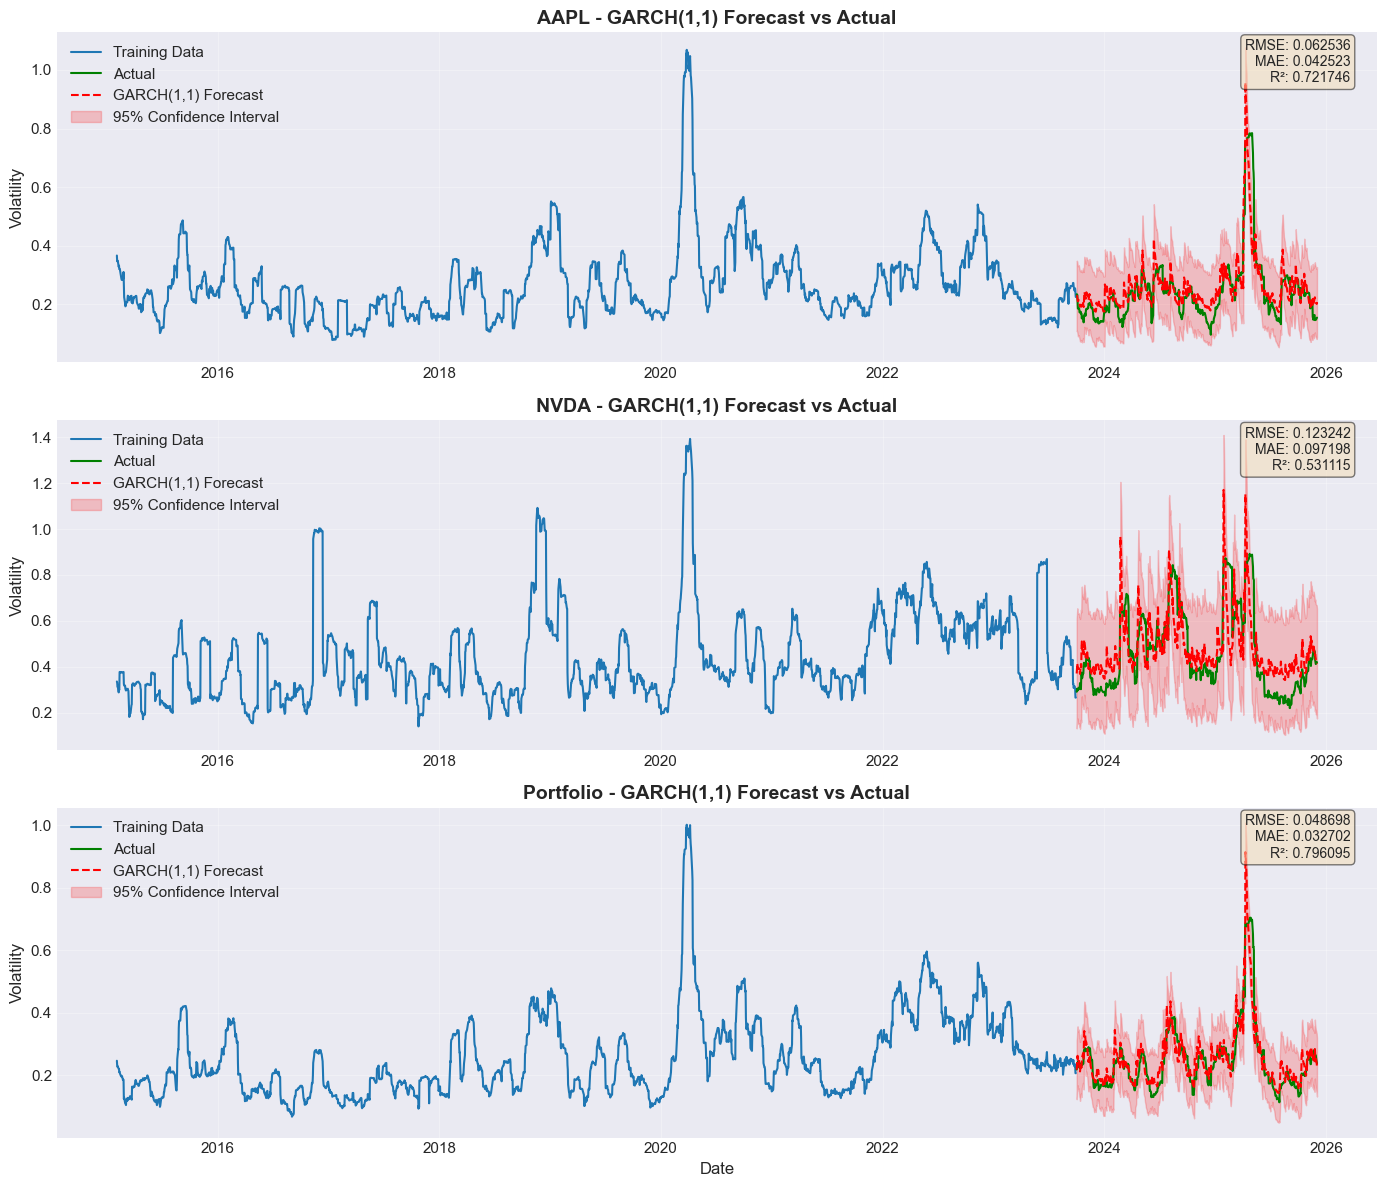

In [27]:
# Plot GARCH results with training and test data
fig, axes = plt.subplots(len(focus_assets), 1, figsize=(14, 12))

for idx, asset in enumerate(focus_assets):
    ax = axes[idx]
    
    # Get data based on asset type
    if asset == 'Portfolio':
        train_actual = train_portfolio['Portfolio_RV_21d']
        test_actual = test_portfolio['Portfolio_RV_21d']
    else:
        train_actual = train_rv[asset]
        test_actual = test_rv[asset]
    
    forecast = garch_results[asset]['garch_vol']
    
    # Plot training data
    ax.plot(train_actual.index, train_actual, label='Training Data', linewidth=1.5)
    
    # Plot test data
    ax.plot(test_actual.index, test_actual, label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    ax.plot(forecast.index, forecast, label='GARCH(1,1) Forecast', 
            linewidth=1.5, color='red', linestyle='--')
    
    # Plot confidence interval
    forecast_std = (forecast - test_actual).std()
    ax.fill_between(forecast.index, 
                     forecast - 1.96 * forecast_std, 
                     forecast + 1.96 * forecast_std,
                     alpha=0.2, color='red', label='95% Confidence Interval')
    
    ax.set_title(f'{asset} - GARCH(1,1) Forecast vs Actual', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volatility', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Add metrics text box
    metrics_text = f"RMSE: {garch_results[asset]['rmse']:.6f}\nMAE: {garch_results[asset]['mae']:.6f}\nR²: {garch_results[asset]['r2']:.6f}"
    ax.text(0.98, 0.98, metrics_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Summary & Conclusion

**Generic Models Underperform**
- ARIMA, Exponential Smoothing, and Prophet treated volatility as generic time series
- Achieved negative or near-zero R² scores, failing to capture volatility clustering and mean reversion
- Generic models assume independence and don't account for conditional heteroskedasticity

**EWMA Performance**
- Explicitly models time-varying variance with exponential decay
- Captures volatility persistence through weighted recent observations
- Simple, parameter-efficient (only λ), computationally fast
- Achieved R² scores around 0.85, demonstrating superior predictive power

**GARCH(1,1) Performance**
- Models conditional variance through past shocks (α) and persistence (β)
- Captures volatility clustering and mean reversion simultaneously
- α + β near 1 indicates high persistence typical of financial volatility
- Achieved R² scores around 0.79, slightly below EWMA

**Portfolio vs Individual Stocks**
- Portfolio volatility is more predictable (higher R² for all models)
- Diversification effect reduces idiosyncratic volatility spikes
- Generic models performed relatively better on portfolio than individual stocks
- Still, GARCH and EWMA significantly outperformed generic approaches

### Conclusion

We demonstrated the fundamental superiority of domain-specific financial models over generic time series approaches for volatility forecasting. Generic methods treated volatility as a standard time series, failing to capture the essential characteristics of financial volatility: clustering (persistence of high/low volatility regimes), conditional heteroskedasticity (time-varying variance), and mean reversion.

In stark contrast, financial econometric models explicitly designed for these dynamics—EWMA and GARCH(1,1)—achieved R² scores of 0.85 and 0.79 respectively, representing transformational predictive power. EWMA's exponentially weighted approach efficiently captures volatility persistence through a single decay parameter, while GARCH models both volatility shocks and persistence simultaneously.

Notably, portfolio volatility proved more predictable than individual stock volatility across all models due to diversification effects reducing idiosyncratic spikes. These results conclusively establish that volatility forecasting requires specialized econometric tools that encode the unique temporal dependencies and structural characteristics of financial markets.